### Imports

In [1]:
import time
import random
import json
from tqdm import tqdm
import os
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler
from torchdata.datapipes.iter import IterableWrapper

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, MetaData, Table, and_

from utils.batch import BatchSamplerSimilarLength, collate_batch
from utils.train import train_model, compute_accuracy
from utils.plot import plot_accuracy, plot_training_loss

from models.lstm import LSTM

/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


### Settings and Hyperparameters

In [2]:
with open ('../settings.json') as f:
    settings = json.load(f)

db_uri = settings['sqlalchemy_database_uri']

RANDOM_SEED = 4321
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 8
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 4

### Define Tokenizer

In [3]:
def custom_tokenizer(line):
    line = line.lower()
    line = line.replace(',', ' ')
    line = line.replace('\\', ' ')
    line = line.replace('\\\\', ' ')
    return line.split()

tokenizer = custom_tokenizer

### Load Data

In [4]:
# list of signatures to load from database
signatures = ['AgentTesla', 'RedLineStealer', 'RaccoonStealer', 'benign']
for signature in signatures:
    # check if json files exist
    if not os.path.isfile(f'{signature}_reports.json'):
        # connect to database
        engine = create_engine(db_uri)

        # load tables
        metadata_obj = MetaData()
        conn = engine.connect()

        Tag = Table('tag', metadata_obj, autoload_with=engine)
        SampleTag = Table('sample_tag', metadata_obj, autoload_with=engine)
        Analysis = Table('analysis', metadata_obj, autoload_with=engine)

        # Start a session
        session = Session(engine)

        reports = []
        bad_reports = []
    
        # get all reports with the tag of signature
        stmt = select(Analysis.c.report).join(SampleTag, Tag.c.id == SampleTag.c.tag_id).join(
            Analysis, SampleTag.c.sample_id == Analysis.c.sample).where(and_(
            (Tag.c.value == signature),
            (Analysis.c.status == 2)
        ))

        results = session.execute(stmt).fetchall()
        print(f"Found {len(results)} {signature} reports")
        report_paths = [r[0] for r in results] 
        # Close the session
        session.close()

        # fetch reports
        for report_path in tqdm(report_paths, desc=f"Reading {signature} reports"):
            try:
                with open(report_path) as f:
                    r = f.read()
                    # tag and append report
                    reports.append([r, signature])
            except:
                bad_reports.append(report_path)
                print(f"Error reading {signature} report: {report_path}. Error number {len(bad_reports)}")
                continue

        # shuffle reports
        random.shuffle(reports)

        # Tokenize reports
        i = 0
        for report in tqdm(reports, desc="Tokenizing reports"):
            dynamic_report = json.loads(report[0])['dynamic']
            dynamic_report_tokenized = []
            for item in dynamic_report:
                line = f"{item['Operation']}, {item['Path']}, {item['Result']}"
                dynamic_report_tokenized.extend(tokenizer(line))
            reports[i][0] = dynamic_report_tokenized
            i += 1

        # json dump reports to file
        print("Dumping reports to file")
        with open(f'{signature}_reports.json', 'w') as f:
            json.dump(reports, f)


In [5]:
# list of signatures to load from database
signatures = ['AgentTesla', 'RedLineStealer', 'RaccoonStealer', 'benign']
reports = []
for signature in signatures:
    with open(f'{signature}_reports.json') as f:
        r = json.load(f)
        reports.extend(r)

In [6]:
len(reports)
# pre-clean reports by removing any reports less than 1,000 or more than 1,000,000 tokens
reports = [r for r in reports if len(r[0]) > 1000 and len(r[0]) < 1000000]
len(reports)

39598

### Data discovery

Number ofreports for AgentTesla: 10155
Mean report length for AgentTesla: 48094.798621368784
Median report length for AgentTesla: 48997.0
Min report length for AgentTesla: 1820
Max report length for AgentTesla: 777067
Standard deviation for AgentTesla: 21827.36482642144
Number of outliers: 2976


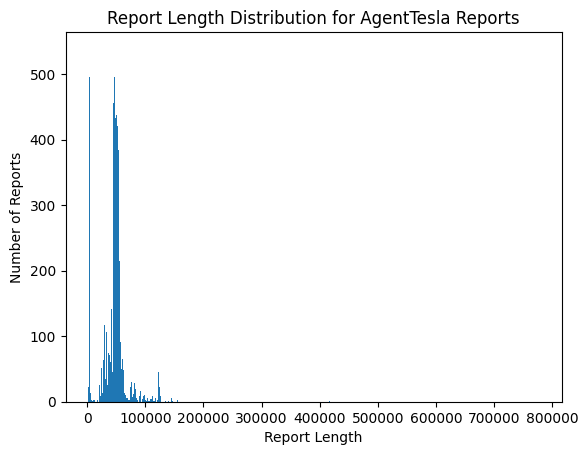

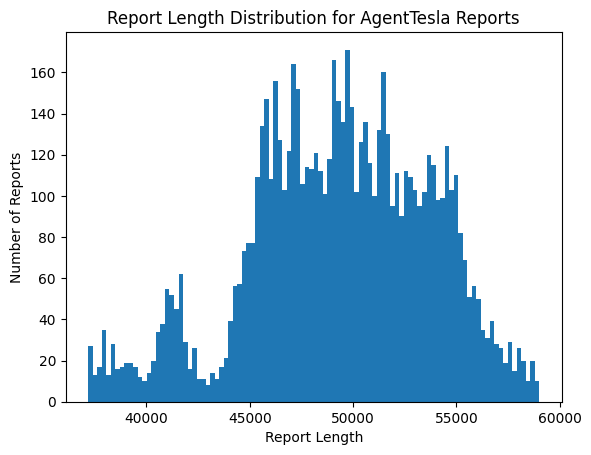

Number ofreports for RedLineStealer: 9774
Mean report length for RedLineStealer: 58561.95794966237
Median report length for RedLineStealer: 64390.0
Min report length for RedLineStealer: 1043
Max report length for RedLineStealer: 606993
Standard deviation for RedLineStealer: 48678.3132693723
Number of outliers: 4205


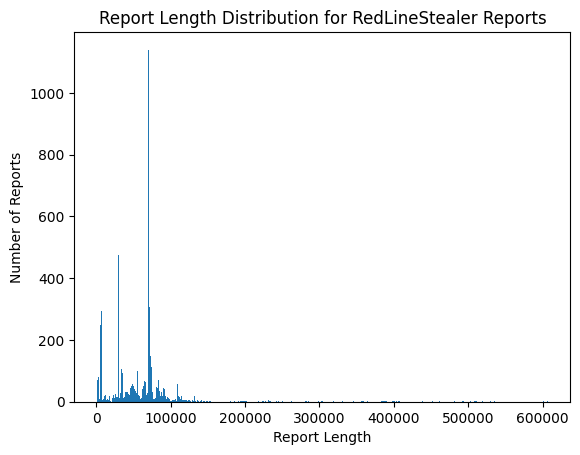

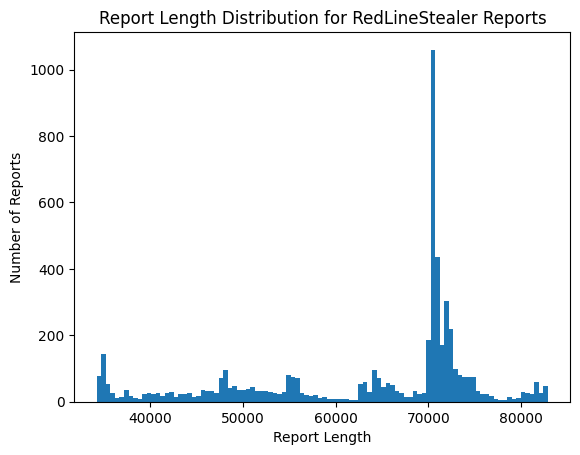

Number ofreports for RaccoonStealer: 9174
Mean report length for RaccoonStealer: 17407.703618923042
Median report length for RaccoonStealer: 12824.0
Min report length for RaccoonStealer: 1626
Max report length for RaccoonStealer: 239065
Standard deviation for RaccoonStealer: 21223.856069237125
Number of outliers: 1362


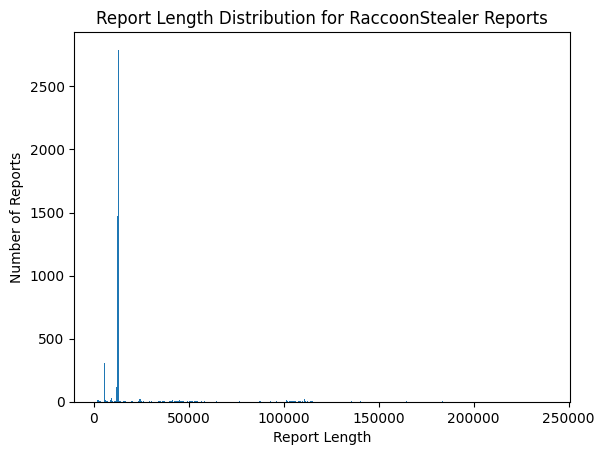

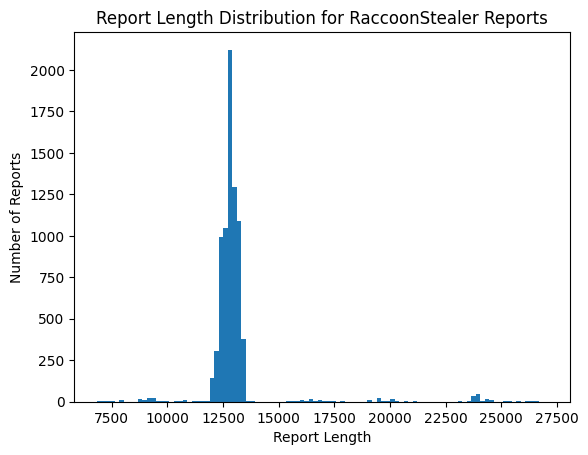

Number ofreports for benign: 7558
Mean report length for benign: 11922.134162476847
Median report length for benign: 3720.0
Min report length for benign: 1001
Max report length for benign: 917923
Standard deviation for benign: 46619.346000236925
Number of outliers: 438


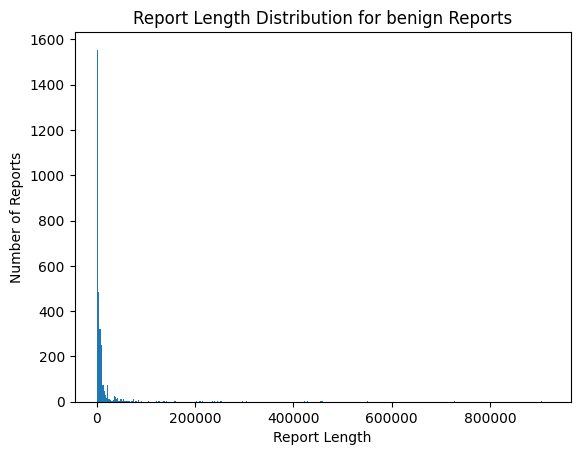

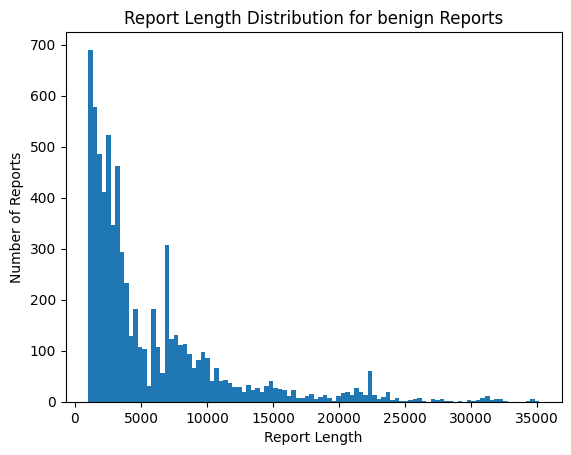

In [7]:
import numpy as np
std_thres = 0.5

# find the mean, median, min, and max lengths of the reports for each signature
for signature in signatures:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    mean_length = np.mean(report_lengths)
    median_length = np.median(report_lengths)
    min_length = min(report_lengths)
    max_length = max(report_lengths)
    std_dev = np.std(report_lengths)

    print(f"Number ofreports for {signature}: {len(report_lengths)}")
    print(f"Mean report length for {signature}: {mean_length}")
    print(f"Median report length for {signature}: {median_length}")
    print(f"Min report length for {signature}: {min_length}")
    print(f"Max report length for {signature}: {max_length}")
    print(f"Standard deviation for {signature}: {std_dev}")

    # find the outliers in the report lengths based on standard deviation

    outliers = [r for r in report_lengths if (r > mean_length + (std_thres * std_dev) or r < mean_length - (std_thres * std_dev))]
    print(f"Number of outliers: {len(outliers)}")

    # graph distribution of the report lengths before removing outliers
    import matplotlib.pyplot as plt
    plt.hist(report_lengths, bins=1000)
    plt.xlabel('Report Length')
    plt.ylabel('Number of Reports')
    plt.title(f'Report Length Distribution for {signature} Reports')
    plt.show()

    # remove outliers
    reports = [r for r in reports if len(r[0]) not in outliers]
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]

    # graph distribution of the report lengths after removing outliers
    plt.hist(report_lengths, bins=100)
    plt.xlabel('Report Length')
    plt.ylabel('Number of Reports')
    plt.title(f'Report Length Distribution for {signature} Reports')
    plt.show()
    


In [8]:
# print the number of reports for each signature after removing outliers
for signature in signatures:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    print(f"Number of reports for {signature}: {len(report_lengths)}")

Number of reports for AgentTesla: 7020
Number of reports for RedLineStealer: 5513
Number of reports for RaccoonStealer: 7812
Number of reports for benign: 7120


In [9]:
# randomly shuffle and select 5000 of each signature
random.shuffle(reports)
selected_reports = []
for signature in signatures:
    selected_reports.extend([r for r in reports if r[1] == signature][:5000])
reports = selected_reports

# print the number of reports for each signature after selecting 5000 of each
for signature in signatures:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    print(f"Number of reports for {signature}: {len(report_lengths)}")

print(f"Total number of reports: {len(reports)}")
random.shuffle(reports)

Number of reports for AgentTesla: 5000
Number of reports for RedLineStealer: 5000
Number of reports for RaccoonStealer: 5000
Number of reports for benign: 5000
Total number of reports: 20000


In [10]:
# find total number of unique tokens in all reports
from collections import Counter
token_counter = Counter()
for report in reports:
    token_counter.update(report[0])

print(f"Total number of unique tokens: {len(token_counter)}")

Total number of unique tokens: 17739


### Split Data

In [11]:
# Split into training, validation, and test sets
dp = IterableWrapper(reports)

# Get the number of rows in dataset
N_ROWS = len(list(dp)) 
N_train = int(N_ROWS * 0.8)
N_valid = int(N_ROWS * 0.1)
N_test = N_ROWS - N_train - N_valid

# Split into training and val datapipes early on. Will build vocabulary from training datapipe only.
train_dp, valid_dp, test_dp = dp.random_split(total_length=N_ROWS, weights={"train": N_train, "valid": N_valid, "test": N_test}, seed=RANDOM_SEED)

print(f'Num Train: {len(train_dp)}')
print(f'Num Validate: {len(valid_dp)}')
print(f'Num Test: {len(test_dp)}')

Num Train: 16000
Num Validate: 2000
Num Test: 2000


### Build Vocabulary

In [12]:
# build vocab
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield text

vocab = build_vocab_from_iterator(yield_tokens(train_dp), specials=["<unk>", "<pad>"], max_tokens=VOCABULARY_SIZE)
vocab.set_default_index(vocab["<unk>"])
PADDING_VALUE=vocab['<pad>']

/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


### Define text and label transforms

In [13]:
text_transform = lambda x: [vocab[token] for token in x]

# label transform for 4 classes
label_transform = lambda x: 0 if x == signatures[0] else 1 if x == signatures[1] else 2 if x == signatures[2] else 3

# # Print out the output of text_transform
# print("input to the text_transform:", "here is an example")
# print("output of the text_transform:", text_transform(list(train_dp)[0][0]))

In [14]:
# batching wrapper
def collate_batch_wrapper(batch):
    return collate_batch(batch=batch, 
                  padding_value=PADDING_VALUE, 
                  device=DEVICE, 
                  text_transform=text_transform, 
                  label_transform=label_transform)

# set up dataloaders
train_dp_list = list(train_dp)
valid_dp_list = list(valid_dp)
test_dp_list = list(test_dp)

train_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = train_dp_list, 
                                                                  batch_size=BATCH_SIZE),
                          collate_fn=collate_batch_wrapper)
valid_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = valid_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch_wrapper)
test_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch_wrapper)

text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([11410, 8])
torch.Size([8])


In [15]:
print('Train')
for text_batch, label_batch in train_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nValid:')
for text_batch, label_batch in valid_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nTest:')
for text_batch, label_batch in test_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

Train
Text matrix size: torch.Size([3945, 8])
Target vector size: torch.Size([8])

Valid:
Text matrix size: torch.Size([70609, 8])
Target vector size: torch.Size([8])

Test:
Text matrix size: torch.Size([70546, 8])
Target vector size: torch.Size([8])


### Train Model

In [16]:
model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/015 | Batch 0000/2000 | Loss: 1.2852
Epoch: 001/015 | Batch 0100/2000 | Loss: 1.3760
Epoch: 001/015 | Batch 0200/2000 | Loss: 1.2089
Epoch: 001/015 | Batch 0300/2000 | Loss: 1.3347
Epoch: 001/015 | Batch 0400/2000 | Loss: 1.2722
Epoch: 001/015 | Batch 0500/2000 | Loss: 1.8767
Epoch: 001/015 | Batch 0600/2000 | Loss: 1.2940
Epoch: 001/015 | Batch 0700/2000 | Loss: 1.3935
Epoch: 001/015 | Batch 0800/2000 | Loss: 1.2641
Epoch: 001/015 | Batch 0900/2000 | Loss: 1.6294
Epoch: 001/015 | Batch 1000/2000 | Loss: 1.3403
Epoch: 001/015 | Batch 1100/2000 | Loss: 1.2018
Epoch: 001/015 | Batch 1200/2000 | Loss: 1.3341
Epoch: 001/015 | Batch 1300/2000 | Loss: 1.5174
Epoch: 001/015 | Batch 1400/2000 | Loss: 1.2617
Epoch: 001/015 | Batch 1500/2000 | Loss: 1.1429
Epoch: 001/015 | Batch 1600/2000 | Loss: 1.2787
Epoch: 001/015 | Batch 1700/2000 | Loss: 1.4954
Epoch: 001/015 | Batch 1800/2000 | Loss: 1.0971
Epoch: 001/015 | Batch 1900/2000 | Loss: 1.1050
Epoch: 001/015 | Train: 49.81% | Validat

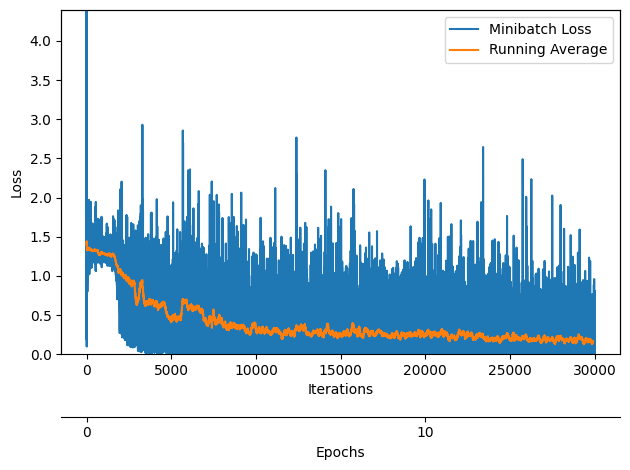

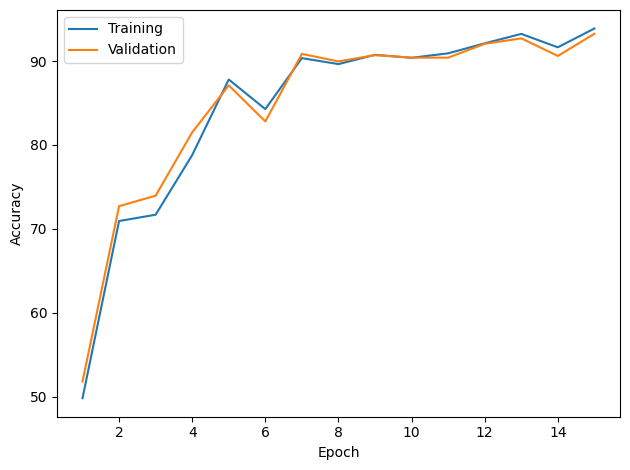

In [17]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

In [18]:
# save model, vocab, and optimizer state
torch.save(model.state_dict(), 'model_data/lstm_mal.pt')
torch.save(optimizer.state_dict(), 'model_data/optimizer_mal.pt')

# save the vocab
with open('model_data/vocab_mal.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [19]:
def get_prediction(model, sentence):

    with torch.no_grad():
        model.eval()
        if type(sentence) == str:
            tokenized = tokenizer(sentence)
        elif type(sentence) == list:
            tokenized = sentence
        else:
            raise TypeError('sentence must be str or list')
        indexed = [vocab[t] for t in tokenized]
        # print(indexed)
        length = [len(indexed)]
        tensor = torch.LongTensor(indexed).to(DEVICE)
        tensor = tensor.unsqueeze(1)
        prediction = F.softmax(model(tensor), dim=1)
    return prediction.to("cpu").squeeze(dim=0).detach().numpy()

In [20]:
for i in range(100):
    report = random.choice(test_dp_list)
    prediction = get_prediction(model, report[0])
    print(f"Report: {label_transform(report[1])}, Prediction: {prediction.argmax()}, {prediction}")

Report: 3, Prediction: 3, [1.9952456e-07 1.0476566e-06 2.1189567e-11 9.9999869e-01]
Report: 1, Prediction: 3, [5.0762850e-05 1.6922766e-05 9.2320290e-10 9.9993229e-01]
Report: 0, Prediction: 0, [9.8520905e-01 1.4394875e-02 4.7212019e-08 3.9607901e-04]
Report: 1, Prediction: 1, [2.8538107e-04 9.9970990e-01 2.4709191e-08 4.6472092e-06]
Report: 1, Prediction: 1, [7.31121254e-05 9.99926805e-01 5.79892045e-09 1.13214554e-07]
Report: 0, Prediction: 0, [9.3442762e-01 6.5569296e-02 1.4567640e-07 3.0052192e-06]
Report: 0, Prediction: 0, [9.8264909e-01 1.6395260e-02 5.6729782e-08 9.5570297e-04]
Report: 1, Prediction: 1, [8.3141749e-05 9.9991667e-01 7.7600459e-09 9.9146774e-08]
Report: 1, Prediction: 1, [1.3578564e-05 9.9998355e-01 2.8843924e-06 7.0459674e-09]
Report: 0, Prediction: 0, [8.3258247e-01 1.6741689e-01 1.3822365e-07 4.9617478e-07]
Report: 1, Prediction: 1, [1.8829046e-01 7.4316198e-01 7.9383838e-08 6.8547465e-02]
Report: 2, Prediction: 0, [0.44099122 0.304316   0.06815418 0.18653856]
